### **Notebook Setup**

**Import Packages**

In [240]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression

from hyperopt import hp
from hyperopt import Trials

from xgboost import *

from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from itertools import combinations

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

**Read in the csv data from file**

In [230]:

# Read the atmospheric river teleconnection pattern dataframe
ar_tcp = pd.read_csv("PacificAR_Strength-Attributes.csv")

# Grab the dataframe values
y = ar_tcp['strength'] # Want to predict the AR's average IVT

# No size characteristics included! 
x = ar_tcp[['BulkAxisDi','SSD_Theta','centroid_y', 'centroid_x', 'PMM', 'QBO', 'MEI', 'Phase','Curvature', 'Displacement','origin_lat', 'origin_lon',
       'Amplitude', 'pna_index_cdas', 'nao_index_cdas','month']] # Using physical characteristics contextualized within a synoptic environment using teleconnection pattern indices

# Seperate into Test-Train splits
X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=42, shuffle=True)

## **Feature Selection**

### **Boruta Feature Selection**

In [232]:
# Initiate the XGboosted regressor
xgb_reg = XGBRegressor()

# Specify the hyperparameter distribution to search
param_dist = {
    'n_estimators': stats.randint(50,500),
    'learning_rate': stats.uniform(0.01, 0.9),
    'num_leaves': stats.randint(20,40)
}

# Tune hyperparameters and conduct Boruta feature selection simultaneously
xgb_regBoruta = BoostBoruta(xgb_reg, max_iter=20, perc=100,
                             importance_type='shap_importances',
                             train_importance=False,
                             param_grid=param_dist,
                             n_iter=20,
                             n_jobs=None,
                             sampling_seed=42)

# Search for optimal combination of features and parameters
xgb_regBoruta.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0) # 2 minutes



20 trials detected for ('n_estimators', 'learning_rate', 'num_leaves')

<class 'int'>
<class 'dict'>


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_sto

trial: 0001 ### iterations: 00162 ### eval_score: 54.8962
<class 'int'>
<class 'dict'>


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_sto

trial: 0002 ### iterations: 00141 ### eval_score: 54.54777
<class 'int'>
<class 'dict'>


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


KeyboardInterrupt: 

**Examining the Results of Boruta**

In [ ]:
print('Attributes before RFE: {}\n'.format(X_train.columns.values))

print('Attributes after RFE: {}\n'.format(X_train.columns[xgb_regBoruta.get_support()].values))

print('Attributes eliminated during RFE: {}\n'.format(X_train.columns[(xgb_regBoruta.get_support()==False)].values))

Attributes before RFE: ['centroid_y' 'centroid_x' 'PMM' 'QBO' 'MEI' 'origin_lat' 'origin_lon'
 'Amplitude' 'pna_index_cdas' 'nao_index_cdas' 'month']

Attributes after RFE: ['centroid_y' 'centroid_x' 'PMM' 'QBO' 'MEI' 'origin_lat' 'origin_lon'
 'Amplitude' 'pna_index_cdas' 'nao_index_cdas' 'month']

Attributes eliminated during RFE: []



*Boruta search hasn't found any attribute to be useless*

### **Recursive Feature Addition**

In [ ]:
# Initiate the XGboosted regressor
xgb_reg = XGBRegressor()

# Specify the hyperparameter distribution to search
param_dist = {
    'n_estimators': stats.randint(50,500),
    'learning_rate': stats.uniform(0.01, 0.9),
    'num_leaves': stats.randint(20,40)
}

# Build the wrapper method
xgb_reg_rfa = BoostRFA(xgb_reg,
                       min_features_to_select=1,
                       step=1,
                       param_grid=param_dist,
                       greater_is_better=False,
                       importance_type='shap_importances',
                       train_importance=False,
                       verbose=1,
                       n_iter=20,
                       n_jobs=None                          
)


# Search for optimal combination of features
xgb_reg_rfa.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6) #1.5 minutes

**Check the Feature Selection's Results**

In [235]:
print('Attributes before RFA: {}\n'.format(X_train.columns.values))

print('Attributes after RFA: {}\n'.format(X_train.columns[xgb_reg_rfa.get_support()].values))

print('Attributes suggested to be eliminated by RFA: {}\n'.format(X_train.columns[(xgb_reg_rfa.get_support()==False)].values))


Attributes before RFA: ['BulkAxisDi' 'SSD_Theta' 'centroid_y' 'centroid_x' 'PMM' 'QBO' 'MEI'
 'Phase' 'Curvature' 'Displacement' 'origin_lat' 'origin_lon' 'Amplitude'
 'pna_index_cdas' 'nao_index_cdas' 'month']

Attributes after RFA: ['BulkAxisDi' 'SSD_Theta' 'centroid_y' 'centroid_x' 'PMM' 'QBO' 'MEI'
 'Curvature' 'Displacement' 'origin_lat' 'origin_lon' 'Amplitude'
 'pna_index_cdas' 'nao_index_cdas' 'month']

Attributes suggested to be eliminated by RFA: ['Phase']



Recursive Feature Addition suggests that the MJO Phase is not a useful attribute

### **Recursive Feature Elimination**

In [ ]:
# Initiate the XGboosted regressor
xgb_reg = XGBRegressor()

# Specify the hyperparameter distribution to search
param_dist = {
    'n_estimators': stats.randint(50,500),
    'learning_rate': stats.uniform(0.01, 0.9),
    'num_leaves': stats.randint(20,40)
}

# Build the wrapper method
xgb_reg_rfe = BoostRFE(xgb_reg,
                       min_features_to_select=1,
                       step=1,
                       param_grid=param_dist,
                       greater_is_better=False,
                       importance_type='shap_importances',
                       train_importance=False,
                       verbose=1,
                       n_iter=20,
                       n_jobs=None                          
)


# Search for optimal combination of features
xgb_reg_rfe.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6) # 9 minutes

 Best Parameters: {'n_estimators': 432, 'learning_rate': 0.387514395454483, 'num_leaves': 20 }

**Examine the results of Recursive Feature Elimination**

In [239]:
print('Attributes before RFE: {}\n'.format(X_train.columns.values))

print('Attributes after RFE: {}\n'.format(X_train.columns[xgb_reg_rfe.get_support()].values))

print('Attributes eliminated during RFE: {}\n'.format(X_train.columns[(xgb_reg_rfe.get_support()==False)].values))

Attributes before RFE: ['BulkAxisDi' 'SSD_Theta' 'centroid_y' 'centroid_x' 'PMM' 'QBO' 'MEI'
 'Phase' 'Curvature' 'Displacement' 'origin_lat' 'origin_lon' 'Amplitude'
 'pna_index_cdas' 'nao_index_cdas' 'month']

Attributes after RFE: ['BulkAxisDi' 'centroid_y' 'centroid_x' 'PMM' 'QBO' 'MEI' 'Curvature'
 'Displacement' 'origin_lat' 'Amplitude' 'pna_index_cdas' 'nao_index_cdas'
 'month']

Attributes eliminated during RFE: ['SSD_Theta' 'Phase' 'origin_lon']



It seems that the Phase is not the only *useless* attribute. We can eliminate SSD_Theta and origin_lon, too.


## **Removing Extraneous Features and Optimizing the Model**

In [244]:
# Remove the Phase, Theta_SSD, and origin_lon
x = ar_tcp[['BulkAxisDi','centroid_y', 'centroid_x', 'PMM', 'QBO', 'MEI','Curvature', 'Displacement','origin_lat',
       'Amplitude', 'pna_index_cdas', 'nao_index_cdas','month']] # Using physical characteristics contextualized within a synoptic environment using teleconnection pattern indices

# Seperate into Test-Train splits
X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=42, shuffle=True)


# Initiate the XGboosted Regressor with the best parameters from RFE
xgb_reg = XGBRegressor(**xgb_reg_rfe.best_params_)
# Fit the model with the training data
xgb_reg.fit(X_train,y_train)


[16:11:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.387514395454483,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=432, n_jobs=None, num_leaves=20,
             num_parallel_tree=None, predictor=None, ...)

Text(0.5, 1.0, 'Optimized Variable Feature Importance')

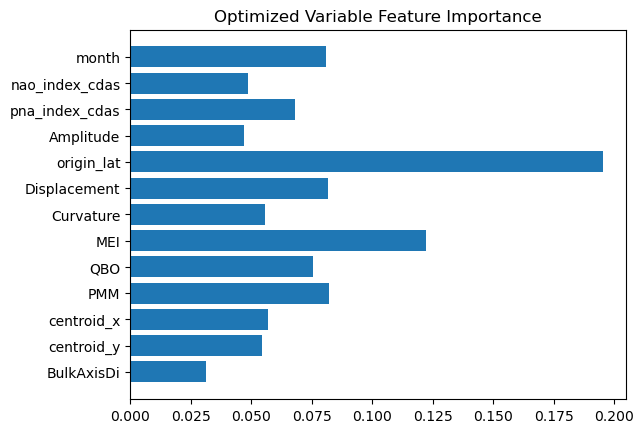

In [253]:
# Examine the feature importances
plt.barh(xgb_reg.feature_names_in_,xgb_reg.feature_importances_)
plt.title('Optimized Variable Feature Importance')

### **Functions**

In [56]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def reg_model_metrics(actual, pred):
    MSE = mean_squared_error(actual, pred) # root mean squared error
    RMSE = np.sqrt(MSE) # root mean squared error
    actual_mean = np.mean(actual) # calculate the mean for use below
    RRMSE = 100 * RMSE / actual_mean # relative root mean squared error
    R2 = r2_score(actual, pred) # coefficient of determination
    return RMSE, RRMSE, R2

def scatter_plot(y_test, y_pred_test, title):
  # Use the model metrics function to calculate RMSE, RRMSE, and R2
    RMSE, RRMSE, R2 = reg_model_metrics(y_test, y_pred_test)
  # Initialize the figure and axis
    fig,ax = plt.subplots(dpi=350)
  # Scatter the y_test vs y_pred_testicted values
    ax.scatter(y_test, y_pred_test, edgecolors=(0,0,0))
  # Plot the line of perfect fir
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
  # Make a few pieces of text that give the values of R2, RMSE, and RRMSE
    text = r"R2 = %.2f" % (R2);text += "\n"; text += r"RMSE = %.2f" % (RMSE); text += "\n"
    text += r"RRMSE = %.2f" % (RRMSE) +'%'
  # Add the text values to a plot at a particular place on the axis within a box
    plt.annotate(text, xy=(0.05, 0.85), xycoords='axes fraction',color='black', fontsize=10,
                 bbox=dict(facecolor='none',edgecolor='red'))
  # Set the x-axis label
    ax.set_xlabel('Actual Average AR IVT')
  # Set the y-axis label
    ax.set_ylabel('Predicted Average AR IVT')
  # Set the plot title
    ax.set_title(title)
  # Set the background color
    fig.patch.set_facecolor('white')
  # Show the plot
    plt.show()